In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print(tf.__version__)

2.7.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.datasets import make_circles

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-11-13 03:00:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-11-13 03:00:57 (40.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [ ]:
unzip_data("/content/drive/MyDrive/datasets/data.zip")

In [ ]:
train_dir="/content/data/train"
test_dir="/content/data/test"

In [ ]:
walk_through_dir("data")

There are 2 directories and 0 images in 'data'.
There are 4 directories and 0 images in 'data/train'.
There are 0 directories and 427 images in 'data/train/fresh cotton leaf'.
There are 0 directories and 288 images in 'data/train/diseased cotton leaf'.
There are 0 directories and 421 images in 'data/train/fresh cotton plant'.
There are 0 directories and 815 images in 'data/train/diseased cotton plant'.
There are 4 directories and 0 images in 'data/test'.
There are 0 directories and 85 images in 'data/test/fresh cotton leaf'.
There are 0 directories and 58 images in 'data/test/diseased cotton leaf'.
There are 0 directories and 93 images in 'data/test/fresh cotton plant'.
There are 0 directories and 106 images in 'data/test/diseased cotton plant'.


In [ ]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,label_mode="categorical",image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,label_mode="categorical",image_size=IMG_SIZE,shuffle=False) # don't shuffle test data for prediction analysis


Found 1951 files belonging to 4 classes.
Found 342 files belonging to 4 classes.


In [ ]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  #preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

In [ ]:
(train_data.class_names)

['diseased cotton leaf',
 'diseased cotton plant',
 'fresh cotton leaf',
 'fresh cotton plant']

In [ ]:
input_shape=(224,224,3)

base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs = layers.Input(shape=input_shape,name="Input_Layer")

x = data_augmentation(inputs)

x = base_model(x , training=False)

x = layers.GlobalAveragePooling2D(name="globalavgpool2D")(x)

outputs = layers.Dense(4, activation="softmax", name="output_layer")(x)

model_1 = tf.keras.Model(inputs , outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 globalavgpool2D (GlobalAver  (None, 1280)             0         
 agePooling2D)                                                   
                                                                 
 output_layer (Dense)        (None, 4)                 5124      
                                                                 
Total params: 4,054,695
Trainable params: 5,124
Non-trainable

In [ ]:
# Compile
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=["accuracy"])

# Fit
history_1 = model_1.fit(train_data,
                                           epochs=5, 
                                           validation_data=test_data,
                                           validation_steps=int(len(test_data)),
                                           callbacks=[checkpoint_callback]) 

Epoch 1/5
61/61 [==============================] - 74s 619ms/step - loss: 0.8122 - accuracy: 0.6838 - val_loss: 1.3618 - val_accuracy: 0.3977
Epoch 2/5
61/61 [==============================] - 29s 467ms/step - loss: 0.4792 - accuracy: 0.8524 - val_loss: 1.2720 - val_accuracy: 0.4708
Epoch 3/5
61/61 [==============================] - 26s 422ms/step - loss: 0.3821 - accuracy: 0.8893 - val_loss: 1.2180 - val_accuracy: 0.4942
Epoch 4/5
61/61 [==============================] - 27s 434ms/step - loss: 0.3316 - accuracy: 0.8990 - val_loss: 1.2504 - val_accuracy: 0.5058
Epoch 5/5
61/61 [==============================] - 25s 396ms/step - loss: 0.2923 - accuracy: 0.9139 - val_loss: 1.1363 - val_accuracy: 0.5556


In [ ]:
# Evaluate model 
results_1 = model_1.evaluate(test_data)
results_1

11/11 [==============================] - 3s 222ms/step - loss: 1.1363 - accuracy: 0.5556


[1.1362825632095337, 0.5555555820465088]

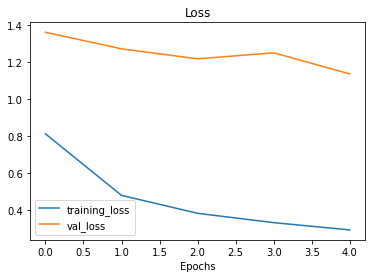

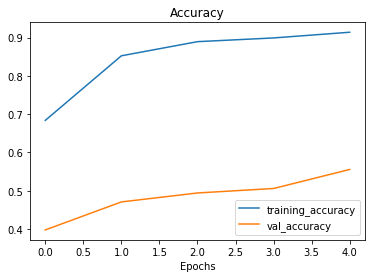

In [ ]:
plot_loss_curves(history_1)

In [ ]:
base_model.trainable=True

for layer in base_model.layers[:-10]:
  layer.trainable=False

In [ ]:
# Recompile model with lower learning rate
model_1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(), # 10x lower learning rate than default
              metrics=['accuracy'])

In [ ]:
for layer in model_1.layers:
  print(layer.name,layer.trainable)

Input_Layer True
data_augmentation True
efficientnetb0 True
globalavgpool2D True
output_layer True


In [ ]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_fine_tune = model_1.fit(train_data,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(len(test_data)), 
                                                     initial_epoch=history_1.epoch[-1]) # start from previous last epoch

Epoch 5/10
61/61 [==============================] - 36s 446ms/step - loss: 0.3066 - accuracy: 0.8913 - val_loss: 0.3484 - val_accuracy: 0.8743
Epoch 6/10
61/61 [==============================] - 24s 377ms/step - loss: 0.1720 - accuracy: 0.9293 - val_loss: 0.6636 - val_accuracy: 0.7544
Epoch 7/10
61/61 [==============================] - 23s 366ms/step - loss: 0.1078 - accuracy: 0.9600 - val_loss: 0.4965 - val_accuracy: 0.8070
Epoch 8/10
61/61 [==============================] - 22s 354ms/step - loss: 0.1063 - accuracy: 0.9651 - val_loss: 0.5099 - val_accuracy: 0.7865
Epoch 9/10
61/61 [==============================] - 21s 328ms/step - loss: 0.0938 - accuracy: 0.9636 - val_loss: 1.4923 - val_accuracy: 0.6725
Epoch 10/10
61/61 [==============================] - 23s 367ms/step - loss: 0.0757 - accuracy: 0.9723 - val_loss: 0.2682 - val_accuracy: 0.9181


In [ ]:
# Evaluate fine-tuned model on the whole test dataset
results_fine_tune = model_1.evaluate(test_data)
results_fine_tune

11/11 [==============================] - 3s 220ms/step - loss: 0.2682 - accuracy: 0.9181


[0.26819562911987305, 0.9181286692619324]

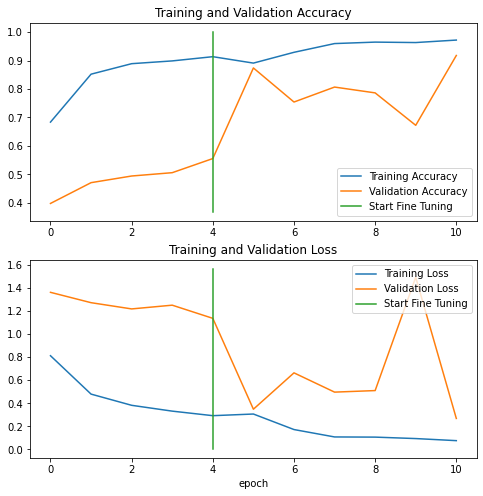

In [ ]:
compare_historys(original_history=history_1,
                 new_history=history_fine_tune,
                 initial_epochs=5)

In [ ]:
preds_probs=model_1.predict(test_data)
len(preds_probs)

342

In [ ]:
pred_classes=preds_probs.argmax(axis=1)
pred_classes,len(pred_classes)

(array([0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 1, 3, 2, 3, 3, 3, 3, 3, 2,
        3, 3, 2, 2, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [ ]:

y_labels = []
for images, labels in test_data.unbatch(): 
  y_labels.append(labels.numpy().argmax()) 
y_labels[:10] 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
len(y_labels)

342

In [ ]:

from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.9181286549707602

In [ ]:
from helper_functions import make_confusion_matrix
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
class_names=test_data.class_names
class_names

['diseased cotton leaf',
 'diseased cotton plant',
 'fresh cotton leaf',
 'fresh cotton plant']

A **Confusion Matrix** is a summarized table of the number of correct and incorrect predictions (or actual and predicted values) yielded by a classifier (or classification model) for binary classification tasks.

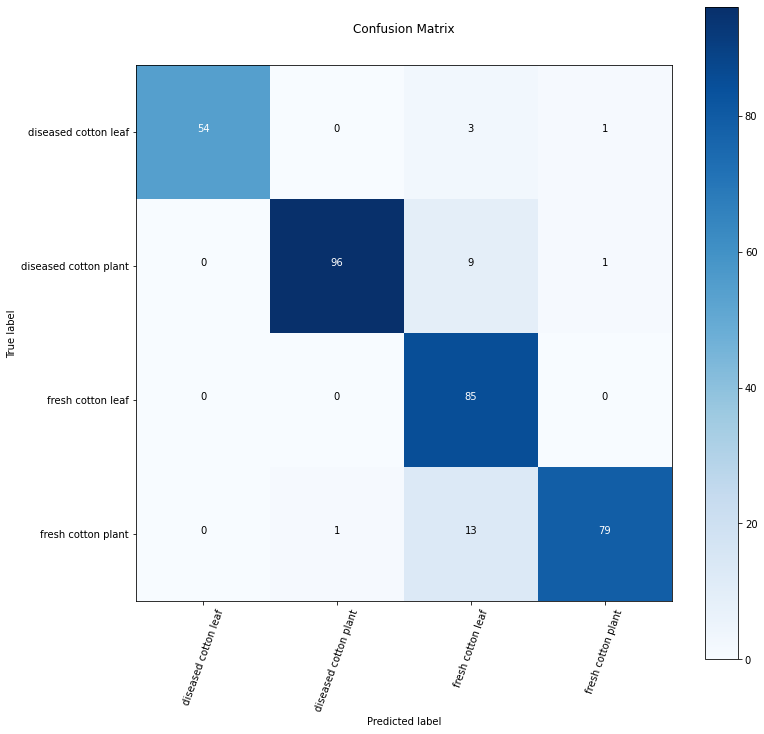

In [ ]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(12,12),
                      text_size=10,
                      norm=False,
                      savefig=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        58
           1       0.99      0.91      0.95       106
           2       0.77      1.00      0.87        85
           3       0.98      0.85      0.91        93

    accuracy                           0.92       342
   macro avg       0.93      0.92      0.92       342
weighted avg       0.93      0.92      0.92       342



**Recall**: It tells us what proportion of Data belonging to a certain class say, class A is classified correctly as in class A by our classifier.


**Precision**: It tells us what proportion of data that our classifier has classified in a certain class, say class A actually belongs to the same class A.

**F1-Score** or F-measure is an evaluation metric for a classification defined as the harmonic mean of precision and recall. It is a statistical measure of the accuracy of a test or model.


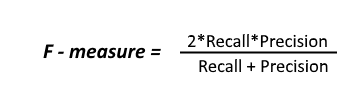


In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.9642857142857143,
  'precision': 1.0,
  'recall': 0.9310344827586207,
  'support': 58},
 '1': {'f1-score': 0.9458128078817735,
  'precision': 0.9896907216494846,
  'recall': 0.9056603773584906,
  'support': 106},
 '2': {'f1-score': 0.8717948717948718,
  'precision': 0.7727272727272727,
  'recall': 1.0,
  'support': 85},
 '3': {'f1-score': 0.9080459770114943,
  'precision': 0.9753086419753086,
  'recall': 0.8494623655913979,
  'support': 93},
 'accuracy': 0.9181286549707602,
 'macro avg': {'f1-score': 0.9224848427434635,
  'precision': 0.9344316590880164,
  'recall': 0.9215393064271273,
  'support': 342},
 'weighted avg': {'f1-score': 0.9202794416043054,
  'precision': 0.9336044981882083,
  'recall': 0.9181286549707602,
  'support': 342}}

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'diseased cotton leaf': 0.9642857142857143,
 'diseased cotton plant': 0.9458128078817735,
 'fresh cotton leaf': 0.8717948717948718,
 'fresh cotton plant': 0.9080459770114943}

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
0,diseased cotton leaf,0.964286
1,diseased cotton plant,0.945813
3,fresh cotton plant,0.908046
2,fresh cotton leaf,0.871795


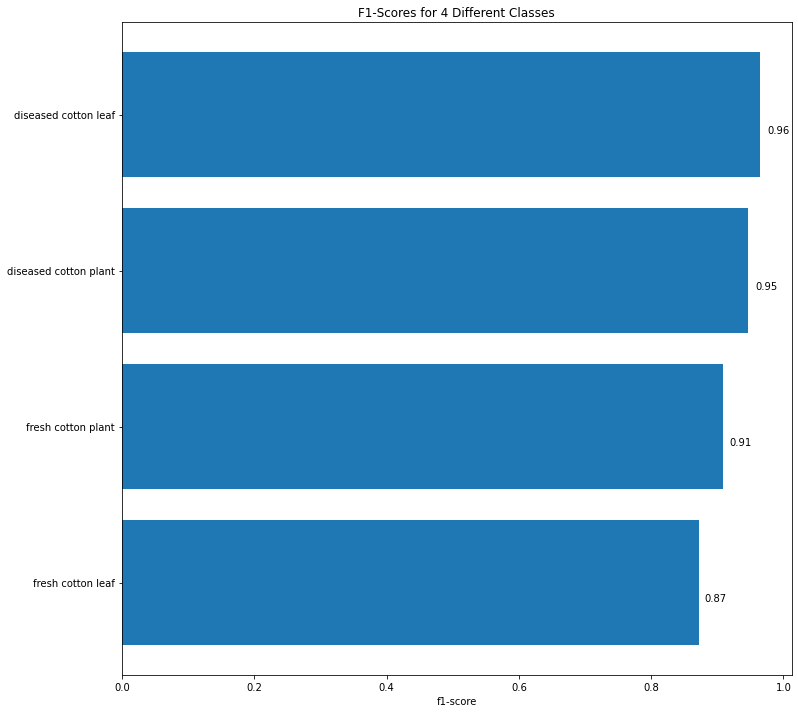

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 12))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 4 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup the target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

In [ ]:
# View a random image from the training dataset
# img = view_random_image(target_dir="/content/data/train",
#                         target_class="/content/data/train/diseased cotton leaf")

In [ ]:
# tf.constant(img)
# img.shape

In [ ]:
fresh_cotton_leaf=load_and_prep_image("/content/data/test/fresh cotton leaf/d (106)_iaip.jpg")
diseased_cotton_leaf=load_and_prep_image("/content/data/test/diseased cotton leaf/dis_leaf (100)_iaip.jpg")

In [ ]:
fresh_cotton_leaf.shape,diseased_cotton_leaf.shape

(TensorShape([224, 224, 3]), TensorShape([224, 224, 3]))

In [ ]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [ ]:
class_names

['diseased cotton leaf',
 'diseased cotton plant',
 'fresh cotton leaf',
 'fresh cotton plant']

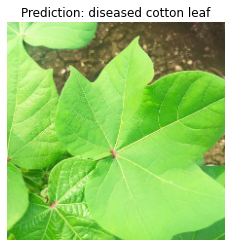

In [ ]:
pred_and_plot(model_1,"/content/data/test/fresh cotton leaf/d (106)_iaip.jpg",class_names)

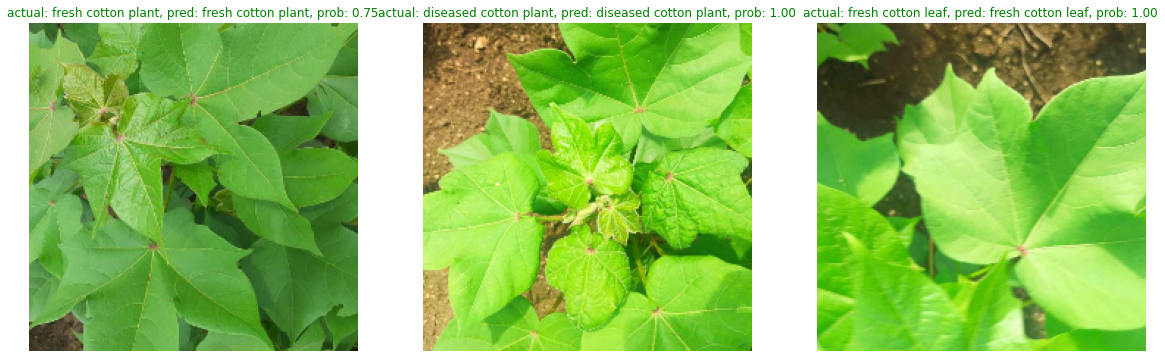

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(20, 10))
for i in range(3):

  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir +"/"+ class_name + "/" + filename

 
  img = load_and_prep_image(filepath, scale=False) 
  pred_prob = model_1.predict(tf.expand_dims(img, axis=0)) 
  pred_class = class_names[pred_prob.argmax()]  

  
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: 
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

In [ ]:
from keras.models import load_model

In [ ]:
model_1.save_weights('model.h5')

In [ ]:
model_json = model_1.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 globalavgpool2D (GlobalAver  (None, 1280)             0         
 agePooling2D)                                                   
                                                                 
 output_layer (Dense)        (None, 4)                 5124      
                                                                 
Total params: 4,054,695
Trainable params: 898,356
Non-trainab

In [ ]:
!pip install tensorflowjs

     |████████████████████████████████| 64 kB 1.1 MB/s 


In [ ]:
import tensorflowjs as tfjs

In [ ]:
tfjs.converters.save_keras_model(model_1,'models')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


weight normalization/count with shape () and dtype int64 was auto converted to the type int32


In [ ]:
# tf.keras.models.save_model(
#     model_1, 'cotton_model', overwrite=True, include_optimizer=True, save_format=None,
#     signatures=None, options=None, save_traces=True
# )


In [ ]:
# tf.keras.models.save_model(model_1,'keras_model.hdf5')

In [ ]:
!pip install gradio

     |████████████████████████████████| 2.0 MB 2.3 MB/s 
     |████████████████████████████████| 1.9 MB 28.3 MB/s 
     |████████████████████████████████| 206 kB 44.6 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 3.5 MB 27.8 MB/s 
     |████████████████████████████████| 961 kB 50.0 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4710 sha256=c64ca28fdf88d86f5bb000b50e9de779c69b0a9b345c8ef8f2808f95affe612b
  Stored in directory: /root/.cache/pip/wheels/13/e4/6c/e8059816e86796a597c6e6b0d4c880630f51a1fcfa0befd5e6
  Created wheel for flask-cachebuster: filename=Flask_CacheBuster-1.0.0-py3-none-any.whl size=3371 sha256=bdb9d0e352285b8643ddd1dd001c3bbd138fe289aeb834f925b851b5e5e9ae4e
  Stored in directory: /root/.cache/pip/wheels/28/c0/c4/44687421dab41455be93112bd1b0dee1f3c5a9aa27bee63708
Successfully built ffmpy flask-cachebuster


In [ ]:
class_names

['diseased cotton leaf',
 'diseased cotton plant',
 'fresh cotton leaf',
 'fresh cotton plant']

In [ ]:
import gradio as gr

In [ ]:
def predict_image(img):
  img_3d=img.reshape(-1,224,224,3)
  im_resize=img_3d
  prediction=model_1.predict(im_resize)[0]
  return {class_names[i]: float(prediction[i]) for i in range(4)}

In [ ]:
image=gr.inputs.Image(shape=(224,224))
label=gr.outputs.Label(num_top_classes=4)

gr.Interface(fn=predict_image,inputs=image,outputs=label,capture_session=True).launch(debug='True')

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://44066.gradio.app

This share link will expire in 72 hours. To get longer links, send an email to: support@gradio.app


KeyboardInterrupt: ignored